In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
from os import path

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from IPython.display import SVG
import re

In [2]:
pairs = pd.read_csv('data/Main_RPAIRS_KEGG.tsv', sep='\t')
pairs['source'] = pairs['Reactant_pair'].apply(lambda x: x.split('_')[0])
pairs['target'] = pairs['Reactant_pair'].apply(lambda x: x.split('_')[1])

# Drop columns that won't be used
pairs.drop(['KEGG_reactions', 'CAR', 'RPAIR_main'], axis=1, inplace=True)
pairs.shape

(10747, 3)

In [3]:
df = pd.read_csv('data/compounds_list_KEGG.csv')
display(df.head())

print(df.shape)

,id,mol_weight,formula
0,C00002,507.1810,C10H16N5O13P3
1,C00003,664.4330,C21H28N7O14P2
2,C00005,745.4209,C21H30N7O17P3
3,C00007,31.9988,O2
4,C00011,44.0095,CO2


(5620, 3)


How many nans

In [4]:
df.isna().sum()

id              0
mol_weight    680
formula         2
dtype: int64

In [5]:
# These are probably mistakes
display(df[df['formula'].isna()])

,id,mol_weight,formula
665,C15778,NaN,NaN
2845,C20798,NaN,NaN


### Fix manually these mistakes

**Correct *C15778***

In [6]:
display(pairs[pairs['source'] == 'C15778'])

display(pairs[pairs['target'] == 'C15778'])

,Reactant_pair,source,target
787,C15778_C15781,C15778,C15781


,Reactant_pair,source,target


According to **KEGG** for the Reaction *R07492*, *C15778* should be *C15780*

In [7]:
pairs.loc[pairs.index[787], 'Reactant_pair'] = 'C15780_C15781'

df.loc[df.index[665], 'id'] = 'C15780'
df.loc[df.index[665], 'mol_weight'] = 396.6484
df.loc[df.index[665], 'formula'] = 'C28H44O'

**Correct *C20798***

In [8]:
display(pairs[pairs['source'] == 'C20798'])

display(pairs[pairs['target'] == 'C20798'])

,Reactant_pair,source,target
5112,C20798_C21180,C20798,C21180
5767,C20798_C20831,C20798,C20831


,Reactant_pair,source,target
890,C19675_C20798,C19675,C20798
2787,C11499_C20798,C11499,C20798


According to **KEGG** for the Reaction *R10719*, *C20798* should be *C21181*

In [9]:
pairs.loc[pairs.index[5112], 'Reactant_pair'] = 'C21181_C21180'
pairs.loc[pairs.index[5767], 'Reactant_pair'] = 'C21181_C20831'
pairs.loc[pairs.index[890], 'Reactant_pair'] = 'C19675_C21181'
pairs.loc[pairs.index[2787], 'Reactant_pair'] = 'C11499_C21181'

df.loc[df.index[2845], 'id'] = 'C21181'
df.loc[df.index[2845], 'mol_weight'] = 154.1417
df.loc[df.index[2845], 'formula'] = 'C3H6O5S'

Recalculate *source* and *target* in pairs

In [10]:
pairs['source'] = pairs['Reactant_pair'].apply(lambda x: x.split('_')[0])
pairs['target'] = pairs['Reactant_pair'].apply(lambda x: x.split('_')[1])

pairs.to_csv('data/Main_RPAIRS_KEGG_fixed.csv', index=None)

## Exctract Features From Chemical Formula

In [11]:
def extract_elements(df, column_name):
    # define the regular expression pattern to match the chemical formula
    pattern = r'[A-Z][a-z]?'
    # initialize a set to store the element symbols
    elements = set()
    # loop over the values in the specified column of the DataFrame
    for value in df[column_name].values:
        # find all matches of the pattern in the value string
        matches = re.findall(pattern, value)
        # add the matches to the set of elements
        elements.update(matches)
    return elements

def extract_stoichiometry(formula):
    # define the regular expression pattern to match the chemical formula
    pattern = r'([A-Z][a-z]?)(\d*)'
    # initialize the dictionary to store the element symbol and its stoichiometry
    stoichiometry = {}
    # loop over the matches of the pattern in the formula string
    for match in re.findall(pattern, formula):
        symbol, count = match
        # if the count is empty, set it to 1
        count = int(count) if count else 1
        # add the symbol and count to the stoichiometry dictionary
        stoichiometry[symbol] = count
    return stoichiometry

# example usage
elements = extract_elements(df, 'formula')
print(elements)

# Create a col for every element
for elm in elements: df[elm]=0

{'P', 'Se', 'Mo', 'N', 'As', 'H', 'I', 'Cl', 'R', 'S', 'F', 'X', 'C', 'Br', 'Zn', 'Mg', 'O', 'Co'}


In [12]:
for row in range(len(df)):
    
    formula = df['formula'].iloc[row]
    stoichiometry = extract_stoichiometry(formula)
    
    for key, value in stoichiometry.items():
        #df[key].iloc[row] = value
        df.loc[df.index[row], key] = value

display(df.head(3))

,id,mol_weight,formula,P,Se,Mo,N,As,H,I,...,R,S,F,X,C,Br,Zn,Mg,O,Co
0,C00002,507.1810,C10H16N5O13P3,3,0,0,5,0,16,0,...,0,0,0,0,10,0,0,0,13,0
1,C00003,664.4330,C21H28N7O14P2,2,0,0,7,0,28,0,...,0,0,0,0,21,0,0,0,14,0
2,C00005,745.4209,C21H30N7O17P3,3,0,0,7,0,30,0,...,0,0,0,0,21,0,0,0,17,0


In [13]:
# Many many compounds with R
print(len(df[df['R']!=0]))

# Col that contains the info if the compound is a polymer or not
df['polymer'] = 0

for row in range(len(df)):
    if 'n' in df['formula'].iloc[row]: 
        df.loc[df.index[row], 'polymer'] = 1
        
# Print how many polymers do we have
print(len(df[df['polymer'] == 1]))

# save to csv
df.to_csv('data/curated.csv')

597
129


# Load curated dataset from Stef - Filled NaN `mol_weight`

In [14]:
df = pd.read_csv('data/curated_complete_mw.csv', index_col=0)
df.drop('mol_weight', axis=1, inplace=True)
df.drop('R.1', axis=1, inplace=True)
df.drop('Mr', axis=1, inplace=True)
df.rename({'N.1':'mol_weight'}, axis=1, inplace=True)
df.head()

,id,formula,Co,C,Br,Zn,N,Mo,S,Se,...,X,H,O,As,F,R,P,Cl,polymer,mol_weight
0,C00002,C10H16N5O13P3,0,10,0,0,5,0,0,0,...,0,16,13,0,0,0,3,0,0,507.0
1,C00003,C21H28N7O14P2,0,21,0,0,7,0,0,0,...,0,28,14,0,0,0,2,0,0,664.0
2,C00005,C21H30N7O17P3,0,21,0,0,7,0,0,0,...,0,30,17,0,0,0,3,0,0,745.0
3,C00007,O2,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,32.0
4,C00011,CO2,0,1,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,44.0


In [33]:
df['mol_weight'].describe()

count    5620.000000
mean      394.297242
std       336.103044
min         2.000000
25%       181.000000
50%       297.500000
75%       483.000000
max      4358.000000
Name: mol_weight, dtype: float64

In [38]:
df[df['mol_weight'] == 4358]

,id,formula,Co,C,Br,Zn,N,Mo,S,Se,...,F,R,P,Cl,polymer,mol_weight,PageRank,Degree Centrality,Betweenness Centrality,mw
2152,C06139,C89H147N6O55R,0,89,0,0,6,0,0,0,...,0,1,0,0,0,4358.0,0.002933,0.003279,0.000048,4370.783367


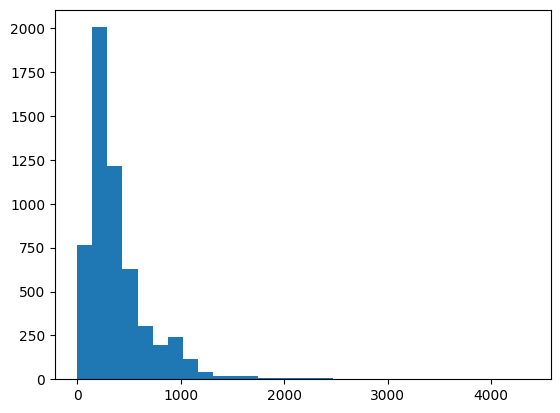

In [37]:
plt.hist(df['mol_weight'], bins=30)
plt.show()

In [15]:
source_mw = df.set_index('id')['mol_weight']
target_mw = source_mw.reindex(pairs['target']).values

pairs['MW'] = abs(source_mw.reindex(pairs['source']).values - target_mw) / (source_mw.reindex(pairs['source']).values + target_mw)

display(pairs.head(3))

,Reactant_pair,source,target,MW
0,C00002_C07024,C00002,C07024,0.001976
1,C00003_C00004,C00003,C00004,0.000752
2,C00005_C00006,C00005,C00006,0.000672


# Import to Networkx 

In [16]:
import networkx as nx

G = nx.Graph()

# iterate over the rows of the DataFrame and add each edge to the graph
for index, row in pairs.iterrows():
    source = row['source']
    target = row['target']
    G.add_edge(source, target)

# Add df cols as node features
node_data = df.set_index('id').to_dict('index')

# Add the node features to the graph
for node, data in G.nodes(data=True):
    node_features = node_data.get(node)
    if node_features:
        data.update(node_features)

print('# nodes:', G.number_of_nodes(), "\n# edges:", G.number_of_edges())

# nodes: 5620 
# edges: 10747


In [17]:
if path.exists('data/nodes_centralities.csv'):
    dc = pd.read_csv('data/nodes_centralities.csv', index_col=0)
else:
    # PageRank
    pr = nx.pagerank(G)
    pr = pd.DataFrame(list(pr.items()), columns=['Node', 'PageRank'])

    # degree centrality
    dc = nx.degree_centrality(G)
    dc = pd.DataFrame(list(dc.items()), columns=['Node', 'Degree Centrality'])
    
    # Betweenness centrality
    bc = nx.betweenness_centrality(G)
    bv = pd.DataFrame(list(bc.items()), columns=['Node', 'Betweenness Centrality'])
    
    # centralities
    dc['PageRank'] = pr['PageRank'].copy()
    dc['Betweenness Centrality'] = bc['Betweenness Centrality'].copy()
    dc.sort_values(by='PageRank', ascending=False, inplace=True)
    dc = pd.merge(dc, df[['id','formula','mol_weight']].rename({'id':'Node'}, axis=1), on='Node')
    dc.to_csv('data/nodes_centralities.csv')

#### Scale the centrality measures

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
dc[['Degree Centrality', 'PageRank', 'Betweenness Centrality']] = scaler.fit_transform(dc[['Degree Centrality', 'PageRank', 'Betweenness Centrality']])
display(dc.head(2))

display(dc.describe().T)

,Node,Degree Centrality,PageRank,Betweenness Centrality,formula,mol_weight
0,C00001,1.000000,1.000000,1.000000,H2O,18.0153
1,C00007,0.780328,0.898108,0.600669,O2,31.9988


,count,mean,std,min,25%,50%,75%,max
Degree Centrality,5620.0,0.003087,0.019770,0.0000,1.092896e-03,0.001093,0.003279,1.0000
PageRank,5620.0,0.003621,0.020670,0.0000,1.266360e-03,0.002221,0.003468,1.0000
Betweenness Centrality,5620.0,0.001034,0.016605,0.0000,1.114510e-07,0.000079,0.000719,1.0000
mol_weight,5620.0,440.817497,328.063873,17.0305,1.881794e+02,320.466300,589.540650,2484.8138


In [19]:
# Concat to df the centrality measures from dc
df = pd.merge(df, dc[['Node', 'PageRank', 'Degree Centrality', 'Betweenness Centrality']], left_on='id', right_on='Node')
df.drop('Node', axis=1, inplace=True)
df.head(2)

,id,formula,Co,C,Br,Zn,N,Mo,S,Se,...,As,F,R,P,Cl,polymer,mol_weight,PageRank,Degree Centrality,Betweenness Centrality
0,C00002,C10H16N5O13P3,0,10,0,0,5,0,0,0,...,0,0,0,3,0,0,507.0,0.220897,0.244809,0.147827
1,C00003,C21H28N7O14P2,0,21,0,0,7,0,0,0,...,0,0,0,2,0,0,664.0,0.007615,0.009836,0.000216


In [20]:
# Create new mw adding info from centrality measure
df['mw'] = df['mol_weight'] + df['mol_weight'] * df['PageRank']

# Update the edge weight
source_mw = df.set_index('id')['mw']
target_mw = source_mw.reindex(pairs['target']).values

pairs['MW_wCentr'] = abs(source_mw.reindex(pairs['source']).values - target_mw) / (source_mw.reindex(pairs['source']).values + target_mw)

display(pairs.head(3))

,Reactant_pair,source,target,MW,MW_wCentr
0,C00002_C07024,C00002,C07024,0.001976,0.100431
1,C00003_C00004,C00003,C00004,0.000752,0.001602
2,C00005_C00006,C00005,C00006,0.000672,0.000305


## Add edge attributes

In [21]:
def get_weights(a,b, method):
    
    # a_C and b_C is the number of C at each compound
    a_C = df[df['id']==a]['C'].values
    b_C = df[df['id']==b]['C'].values
    if (a_C != 0 and b_C == 0) or (a_C == 0 and b_C != 0):
        return 999
    
    try:
        w = pairs[(pairs['source'] == a) & (pairs['target'] == b)][method].values[0]
    except IndexError:
        w = pairs[(pairs['source'] == b) & (pairs['target'] == a)][method].values[0]
    
    return w

for edge in G.edges():
    G.edges[(edge[0], edge[1])]['weight'] = \
            get_weights(edge[0], edge[1], method='MW')

In [22]:
source = 'C00031'
target = 'C00074'
paths = nx.shortest_simple_paths(G, source, target, weight='weight')

In [23]:
for idx, val in enumerate(paths):
    print(val)
    if idx == 9: break

['C00031', 'C00092', 'C00085', 'C00118', 'C00111', 'C00074']
['C00031', 'C00092', 'C00093', 'C00111', 'C00074']
['C00031', 'C00092', 'C00093', 'C00118', 'C00111', 'C00074']
['C00031', 'C00092', 'C00085', 'C00199', 'C00118', 'C00111', 'C00074']
['C00031', 'C00092', 'C00085', 'C00279', 'C03604', 'C03394', 'C00111', 'C00074']
['C00031', 'C00092', 'C00644', 'C00085', 'C00118', 'C00111', 'C00074']
['C00031', 'C00092', 'C00644', 'C00085', 'C00199', 'C00118', 'C00111', 'C00074']
['C00031', 'C00092', 'C00644', 'C00085', 'C00279', 'C03604', 'C03394', 'C00111', 'C00074']
['C00031', 'C00198', 'C00124', 'C00095', 'C00085', 'C00118', 'C00111', 'C00074']
['C00031', 'C00198', 'C00124', 'C00092', 'C00085', 'C00118', 'C00111', 'C00074']


In [24]:
source = 'C00074'
target = 'C02637'
paths = nx.shortest_simple_paths(G, source, target, weight='weight')

In [28]:
for idx, val in enumerate(paths):
    print(val)
    if idx == 3: break

['C00074', 'C02798', 'C05672', 'C00025', 'C00045', 'C00047', 'C03239', 'C00161', 'C00026', 'C03232', 'C00197', 'C00118', 'C00111', 'C03394', 'C03604', 'C00279', 'C04691', 'C00944', 'C02637']
['C00074', 'C02798', 'C00026', 'C00161', 'C00045', 'C00025', 'C01005', 'C03232', 'C00197', 'C00118', 'C00093', 'C00111', 'C03394', 'C03604', 'C00279', 'C04691', 'C00944', 'C02637']
['C00074', 'C02798', 'C00026', 'C00940', 'C00064', 'C00025', 'C01005', 'C03232', 'C00197', 'C00118', 'C00093', 'C00111', 'C03394', 'C03604', 'C00279', 'C04691', 'C00944', 'C02637']
['C00074', 'C02798', 'C00026', 'C00161', 'C03239', 'C00047', 'C00025', 'C01005', 'C03232', 'C00197', 'C00118', 'C00093', 'C00111', 'C03394', 'C03604', 'C00279', 'C04691', 'C00944', 'C02637']


In [29]:
source = 'C00082'
target = 'C02637'
list(nx.all_shortest_paths(G, source, target, weight='weight'))

[['C00082',
  'C00826',
  'C00254',
  'C00251',
  'C01269',
  'C03175',
  'C00493',
  'C02637'],
 ['C00082',
  'C00826',
  'C00254',
  'C00251',
  'C01269',
  'C03175',
  'C00493',
  'C02637']]

In [27]:
source = 'C07481'
target = 'C00385'
list(nx.all_shortest_paths(G, source, target, weight='weight'))

[['C07481', 'C07130', 'C16357', 'C00385'],
 ['C07481', 'C07480', 'C16357', 'C00385'],
 ['C07481', 'C07130', 'C16358', 'C00385'],
 ['C07481', 'C13747', 'C16358', 'C00385'],
 ['C07481', 'C07480', 'C16353', 'C00385'],
 ['C07481', 'C13747', 'C16353', 'C00385']]

### Load file with test cases fron NICEpath

In [30]:
test_cases = pd.read_csv('data/test_cases.csv')
test_cases['source'] = test_cases['Pathway '].apply(lambda x: x.split(',')[0])
test_cases['target'] = test_cases['Pathway '].apply(lambda x: x.split(',')[len(x.split(','))-1])
test_cases.head(3)

,Pathway,source,target
0,"C00082,C00811,C01197,C01494,C05619,C00482,C056...",C00082,C01533
1,"C00223,C00323,C00406,C02666,C00590,C00761",C00223,C00761
2,"C00811,C01197,C01494,C05619,C00482,C01175,C02887",C00811,C02887


In [31]:
for row in range(len(test_cases)):
    source = test_cases['source'].iloc[row]
    target = test_cases['target'].iloc[row]
    print(list(nx.shortest_path(G, source, target, weight='weight')))

['C00082', 'C00811', 'C01197', 'C01494', 'C05619', 'C00482', 'C05610', 'C02325', 'C01533']
['C00223', 'C12096', 'C00029', 'C00761']
['C00811', 'C01197', 'C01494', 'C05619', 'C00482', 'C01175', 'C02887']
['C00079', 'C00166', 'C05607', 'C16257', 'C00540', 'C00903']
['C00223', 'C12096', 'C00029', 'C17750']
['C06561', 'C00509', 'C16492', 'C01460']
['C05903', 'C12249', 'C00029', 'C12635', 'C12636']
['C01477', 'C01460', 'C00029', 'C00167', 'C04900']
['C05903', 'C00389', 'C10107', 'C12633', 'C11620']
['C05905', 'C08604', 'C08639', 'C12096', 'C16299']
['C05904', 'C12137', 'C12642', 'C00083', 'C12647']
['C05908', 'C12138', 'C00029', 'C16303']
['C00078', 'C00398', 'C21762', 'C21778', 'C21779', 'C07576']
['C06160', 'C06161', 'C00019', 'C21591', 'C20299']
['C05191', 'C05247', 'C05194', 'C05193', 'C05316', 'C06165']
['C00079', 'C00166', 'C05607', 'C16257', 'C10860']
['C00047', 'C04076', 'C00450', 'C00408']
['C07481', 'C07130', 'C16357', 'C00385']
['C00082', 'C00355', 'C03758', 'C08557']
['C08539', 

__UDP__: `C00015`

### Get node embeddings using GNN and Clustering (idea)

In [41]:
df_copy = df.copy()

In [42]:
from sklearn.preprocessing import StandardScaler

'''Scale df'''
# Select the columns with non-object data types
numeric_cols = df.select_dtypes(include=['int', 'float']).columns

# Apply standard scaling to the selected columns
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

'''Recreate Graph'''
G = nx.Graph()

# iterate over the rows of the DataFrame and add each edge to the graph
for index, row in pairs.iterrows():
    source = row['source']
    target = row['target']
    G.add_edge(source, target)

# Add df cols as node features
node_data = df.set_index('id').to_dict('index')

# Add the node features to the graph
for node, data in G.nodes(data=True):
    node_features = node_data.get(node)
    if node_features:
        data.update(node_features)

print('# nodes:', G.number_of_nodes(), "\n# edges:", G.number_of_edges())

# nodes: 5620 
# edges: 10747


In [43]:
from torch_geometric.utils.convert import from_networkx
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv
import torch
import torch.nn as nn
import torch.nn.functional as F

node_features = [col for col in df.drop(['id', 'formula'], axis=1).columns]

data = from_networkx(G, group_node_attrs=node_features)
print(data.x.shape)

# Map node names to integers
mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, mapping)

# Add a new column to data.x with the node names from the mapping
node_names = [None] * len(data.x)
for node, index in mapping.items():
    node_names[index] = node
    
graph_data = np.column_stack((data.x, node_names))
graph_data = pd.DataFrame(graph_data)

display(graph_data.head())

torch.Size([5620, 24])


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.046257976,-0.47569066,-0.05800596,-0.01334045,1.6516563,-0.023110451,-0.35957474,-0.049973235,-0.055536322,-0.07916304,...,-0.3170322,3.0319724,-0.14800134,-0.15327422,0.33535188,10.512794,12.227794,8.841075,0.6630738,C00002
1,-0.046257976,-0.47569066,-0.05800596,-0.01334045,1.6516563,-0.023110451,-0.35957474,-0.049973235,-0.055536322,-0.07916304,...,-0.3170322,3.0319724,-0.14800134,-0.15327422,0.32940078,-0.07844049,-0.045585938,-0.06089741,0.3278283,C07024
2,-0.046257976,0.38326472,-0.05800596,-0.01334045,2.576834,-0.023110451,-0.35957474,-0.049973235,-0.055536322,-0.07916304,...,-0.3170322,1.8777567,-0.14800134,-0.15327422,0.8025121,0.1932823,0.3414125,-0.049249347,0.81161666,C00003
3,-0.046257976,0.38326472,-0.05800596,-0.01334045,2.576834,-0.023110451,-0.35957474,-0.049973235,-0.055536322,-0.07916304,...,-0.3170322,1.8777567,-0.14800134,-0.15327422,0.80548763,-0.035750844,0.009699554,-0.061821274,0.80526626,C00004
4,-0.046257976,0.38326472,-0.05800596,-0.01334045,2.576834,-0.023110451,-0.35957474,-0.049973235,-0.055536322,-0.07916304,...,-0.3170322,3.0319724,-0.14800134,-0.15327422,1.0435311,-0.08419381,-0.045585938,-0.06004852,1.041111,C00005


In [44]:
class SAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers):
        super(SAGE, self).__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else hidden_channels
            self.convs.append(SAGEConv(in_channels, hidden_channels))

    def forward(self, x, adjs):
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    def full_forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SAGE(data.num_node_features, hidden_channels=4, \
             num_layers=1)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

x, edge_index = data.x.to(device), data.edge_index.to(device)

# Forward propagate the graph through the model
model.eval()
with torch.no_grad():
    out = model.full_forward(data.x, data.edge_index)

# Extract the node embeddings
node_embeddings = out.numpy()  # or out.detach().numpy() if using PyTorch version <1.6

# Print the shape of the node embeddings matrix
print('Node embeddings shape:', node_embeddings.shape)

Node embeddings shape: (5620, 4)


In [148]:
node_embeddings=pd.DataFrame(node_embeddings)
node_embeddings['id']  = graph_data[graph_data.shape[1]-1]
# node_embeddings.set_index('id', inplace=True)
node_embeddings

,0,1,2,3,id
0,0.441722,-0.347565,-2.931345,0.594922,C00002
1,0.597105,1.616578,1.081657,-0.932573,C07024
2,0.461805,1.199976,0.614995,-0.415841,C00003
3,0.393747,1.137706,0.687152,-0.301356,C00004
4,0.593800,1.507571,1.299703,-0.936374,C00005
...,...,...,...,...,...
5615,4.777917,3.426768,-0.974567,-0.767836,C16487
5616,-0.086657,0.286581,0.003130,0.550068,C00237
5617,0.838591,-0.145284,1.091916,-1.103059,C05232
5618,0.010520,0.095059,-0.517729,0.396282,C00283


In [149]:
node_embeddings[node_embeddings['id'] == 'C00811']

,0,1,2,3,id
2836,0.120062,0.357436,0.464212,-0.107965,C00811


In [150]:
node_embeddings[node_embeddings['id'] == 'C00013']

,0,1,2,3,id
4147,0.034261,-0.132567,-1.27845,0.256991,C00013


In [151]:
node_embeddings[node_embeddings['id'] == 'C00146']

,0,1,2,3,id
3809,-0.006893,0.218506,0.591352,-0.033146,C00146


In [158]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

# Suppose you have the node embeddings in a dictionary called 'embeddings'
u_embedding = node_embeddings.iloc[62,:-1]
v_embedding = node_embeddings.iloc[3809,:-1]

similarity = cosine_similarity(u_embedding.values.reshape(1, -1), v_embedding.values.reshape(1, -1))[0, 0]
print(similarity)

0.4756511205004293


In [153]:
similarity, _ = pearsonr(u_embedding, v_embedding)
print(similarity)

0.38470953227899024


In [154]:
distance = np.linalg.norm(u_embedding - v_embedding)
similarity = 1 / (1 + distance)
print(similarity)

0.24253645835351192


In [159]:
# Add cosine similarity from embedding to pairs 
cos_sim = []
for row in range(len(pairs)):
    
    source = pairs['source'].iloc[row]
    target = pairs['target'].iloc[row]
    
    u_embedding = node_embeddings[node_embeddings['id'] == source].iloc[0, :-1]
    v_embedding = node_embeddings[node_embeddings['id'] == target].iloc[0, :-1]

    similarity = cosine_similarity(u_embedding.values.reshape(1, -1), v_embedding.values.reshape(1, -1))[0, 0]
    cos_sim.append(similarity)
    
pairs['cos_sim'] = cos_sim
# pairs['cos_sim'] = (pairs['cos_sim'] + 1) / 2
pairs['cos_sim'] = 1 - pairs['cos_sim']

pairs.head()

,Reactant_pair,source,target,MW,MW_wCentr,cos_sim
0,C00002_C07024,C00002,C07024,0.001976,0.100431,1.590680
1,C00003_C00004,C00003,C00004,0.000752,0.001602,0.005330
2,C00005_C00006,C00005,C00006,0.000672,0.000305,0.004183
3,C00007_C00027,C00007,C00027,0.030303,0.280698,1.898238
4,C00011_C00058,C00011,C00058,0.022222,0.053514,0.437329


In [162]:
print(pairs['cos_sim'].describe())

pairs['cos_sim'] = pairs['cos_sim'].apply(lambda x: max(0,x))

count    1.074700e+04
mean     9.511019e-01
std      7.280763e-01
min     -2.220446e-16
25%      1.909888e-01
50%      9.043138e-01
75%      1.726002e+00
max      1.998921e+00
Name: cos_sim, dtype: float64


# Import to Networkx 

In [163]:
import networkx as nx

df = df_copy.copy()
G = nx.Graph()

# iterate over the rows of the DataFrame and add each edge to the graph
for index, row in pairs.iterrows():
    source = row['source']
    target = row['target']
    G.add_edge(source, target)

# Add df cols as node features
node_data = df.set_index('id').to_dict('index')

# Add the node features to the graph
for node, data in G.nodes(data=True):
    node_features = node_data.get(node)
    if node_features:
        data.update(node_features)

print('# nodes:', G.number_of_nodes(), "\n# edges:", G.number_of_edges())

# nodes: 5620 
# edges: 10747


## Add edge attributes

In [164]:
def get_weights(a,b, method):
    
    # a_C and b_C is the number of C at each compound
    a_C = df[df['id']==a]['C'].values
    b_C = df[df['id']==b]['C'].values
    if (a_C != 0 and b_C == 0) or (a_C == 0 and b_C != 0):
        return 999
    
    try:
        w = pairs[(pairs['source'] == a) & (pairs['target'] == b)][method].values[0]
    except IndexError:
        w = pairs[(pairs['source'] == b) & (pairs['target'] == a)][method].values[0]
    
    return w

for edge in G.edges():
    G.edges[(edge[0], edge[1])]['weight'] = \
            get_weights(edge[0], edge[1], method='cos_sim')

In [165]:
source = 'C00082'
target = 'C01533'
list(nx.shortest_path(G, source, target, weight='weight'))

['C00082',
 'C00811',
 'C01197',
 'C01494',
 'C05619',
 'C00482',
 'C05610',
 'C02325',
 'C01533']

In [166]:
source = 'C07481'
target = 'C00385'
list(nx.shortest_path(G, source, target, weight='weight'))

['C07481', 'C13747', 'C00067', 'C16353', 'C00385']

### Load file with test cases fron NICEpath

In [167]:
test_cases = pd.read_csv('data/test_cases.csv')
test_cases['source'] = test_cases['Pathway '].apply(lambda x: x.split(',')[0])
test_cases['target'] = test_cases['Pathway '].apply(lambda x: x.split(',')[len(x.split(','))-1])
test_cases.head(3)

,Pathway,source,target
0,"C00082,C00811,C01197,C01494,C05619,C00482,C056...",C00082,C01533
1,"C00223,C00323,C00406,C02666,C00590,C00761",C00223,C00761
2,"C00811,C01197,C01494,C05619,C00482,C01175,C02887",C00811,C02887


In [168]:
for row in range(len(test_cases)):
    source = test_cases['source'].iloc[row]
    target = test_cases['target'].iloc[row]
    print(list(nx.shortest_path(G, source, target, weight='weight')))

['C00082', 'C00811', 'C01197', 'C01494', 'C05619', 'C00482', 'C05610', 'C02325', 'C01533']
['C00223', 'C00323', 'C00406', 'C12203', 'C05619', 'C01494', 'C02666', 'C00590', 'C00761']
['C00811', 'C01197', 'C01494', 'C05619', 'C00482', 'C01175', 'C02887']
['C00079', 'C00082', 'C00811', 'C01197', 'C01494', 'C05619', 'C12203', 'C00406', 'C00323', 'C00223', 'C00540', 'C00903']
['C00223', 'C00323', 'C00406', 'C17741', 'C10443', 'C17749', 'C17750']
['C06561', 'C00509', 'C16492', 'C01460']
['C05903', 'C12249', 'C12634', 'C12635', 'C12636']
['C01477', 'C04608', 'C04858', 'C01623', 'C00015', 'C00167', 'C04900']
['C05903', 'C00389', 'C10107', 'C12633', 'C11620']
['C05905', 'C08604', 'C08639', 'C12096', 'C16299']
['C05904', 'C12137', 'C08725', 'C12640', 'C12641', 'C12647']
['C05908', 'C12138', 'C16301', 'C16304', 'C16303']
['C00078', 'C00398', 'C21762', 'C21778', 'C21779', 'C07576']
['C06160', 'C03758', 'C00355', 'C00082', 'C02993', 'C00062', 'C00179', 'C00134', 'C00041', 'C00037', 'C00025', 'C0001